# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py

In [1]:
from __future__ import division, print_function, absolute_import
%pylab inline

import tensorflow as tf
import numpy as np
import os
import librosa
from  librosa.util import frame

%run ../../utils.py
%run ../nnutils.py

rc_default()

SAVEFIG = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'
fname = 'Grisey_partiels.wav'
# fname = 'Xenakis_Metastasis.wav'

name = fname[:-4]

filename = path+fname

fs,track = wav2audio_segment(filename,0,160)

NFFT = 2**11
HOP = int(NFFT/4)

STFT = librosa.stft(track,n_fft=NFFT, hop_length=HOP,center=False)
mel = librosa.feature.melspectrogram(S=abs(STFT)**2)

X = mel

block_length = 16
idx = frame(arange(X.shape[1]),frame_length=block_length, hop_length=int(block_length/2))
X_blocks = abs(X)[:,idx]
X_blocks = np.rollaxis(X_blocks,2)

/usr/local/lib/python3.5/dist-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


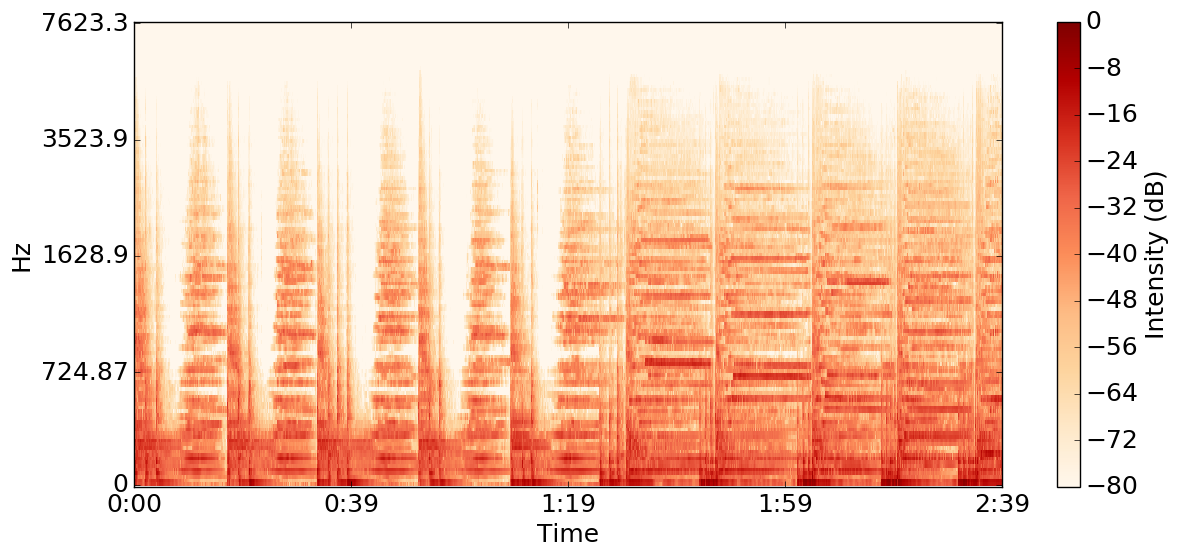

In [3]:
figure(figsize=(14,6))

librosa.display.specshow(librosa.logamplitude(X,ref_power=np.max),hop_length = HOP, sr=fs,y_axis='mel', fmax=8000, x_axis='time')
colorbar(label='Intensity (dB)')

if SAVEFIG: savefig('../../talk/figs/'+name+'_melspectrum.png')
    

In [4]:
print("Dimensions: data length, freq bins, time bins")
total_length, freq_bins,time_bins = X_blocks.shape
print(total_length, freq_bins,time_bins)
print("Number of frames per block",block_length)
print(block_length*NFFT/fs,'seconds')
print("Overlap of frames per block:",block_length/2)
print(block_length*NFFT/fs/2,'seconds')

Dimensions: data length, freq bins, time bins
1721 128 16
Number of frames per block 16
0.7430385487528345 seconds
Overlap of frames per block: 8.0
0.37151927437641724 seconds


## Create dataset  (Data class) with spectrum frames

In [5]:
mean_img = X_blocks.mean(0)
std_img = X_blocks.std(0)
X_blocks = (X_blocks-mean_img)/std_img
data = Data( X_blocks.reshape((X_blocks.shape[0],freq_bins*time_bins)) )

## Convolutional Autoencoder parameters

In [6]:
display_step = 10
batch_size = 400
n_epochs = 300
learning_rate = 0.002
l2scale = 0.01
n_filters=[16,16,16,16]
n_features =  int(data.data.shape[1])
input_shape = [None, n_features]
filter_sizes = [4,4,4,2]
strides = [[1, 2, 2, 1],
           [1, 2, 2, 1],
           [1, 2, 2, 1],
           [1, 2, 2, 1]]

In [7]:
cae = CAE(input_shape,freq_bins,time_bins, n_filters, filter_sizes, strides)
cae.train(data, batch_size, n_epochs)
sess = cae.get_session()
ae_dict = cae.get_aedict()

Encoding
N Filters [16, 16, 16, 16]
Filter sizes [4, 4, 4, 2]
Shapes [[None, 128, 16, 1], [None, 64, 8, 16], [None, 32, 4, 16], [None, 16, 2, 16]]
Decoding
N Filters [16, 16, 16, 1]
Filter sizes [4, 4, 4, 2]
Shapes [[None, 16, 2, 16], [None, 32, 4, 16], [None, 64, 8, 16], [None, 128, 16, 1]]
Epoch: 0000 cost= 1.022850752
Epoch: 0010 cost= 0.860343754
Epoch: 0020 cost= 0.778281569
Epoch: 0030 cost= 0.738909662
Epoch: 0040 cost= 0.614625335
Epoch: 0050 cost= 0.568386972
Epoch: 0060 cost= 0.476227403
Epoch: 0070 cost= 0.452831954
Epoch: 0080 cost= 0.431664586
Epoch: 0090 cost= 0.402461469
Epoch: 0100 cost= 0.384577841
Epoch: 0110 cost= 0.364488065
Epoch: 0120 cost= 0.369488984
Epoch: 0130 cost= 0.397956014
Epoch: 0140 cost= 0.366372973
Epoch: 0150 cost= 0.358946413
Epoch: 0160 cost= 0.357557893
Epoch: 0170 cost= 0.352422029
Epoch: 0180 cost= 0.343410641
Epoch: 0190 cost= 0.337031484
Epoch: 0200 cost= 0.321844101
Epoch: 0210 cost= 0.317894191
Epoch: 0220 cost= 0.330547184
Epoch: 0230 cost=

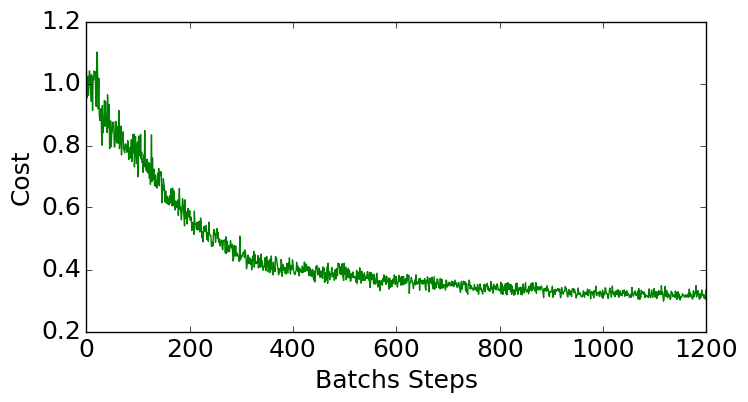

In [8]:
figure(figsize=(8,4))
plot(cae.get_costlist(),'g')
ylabel('Cost')
xlabel('Batchs Steps');

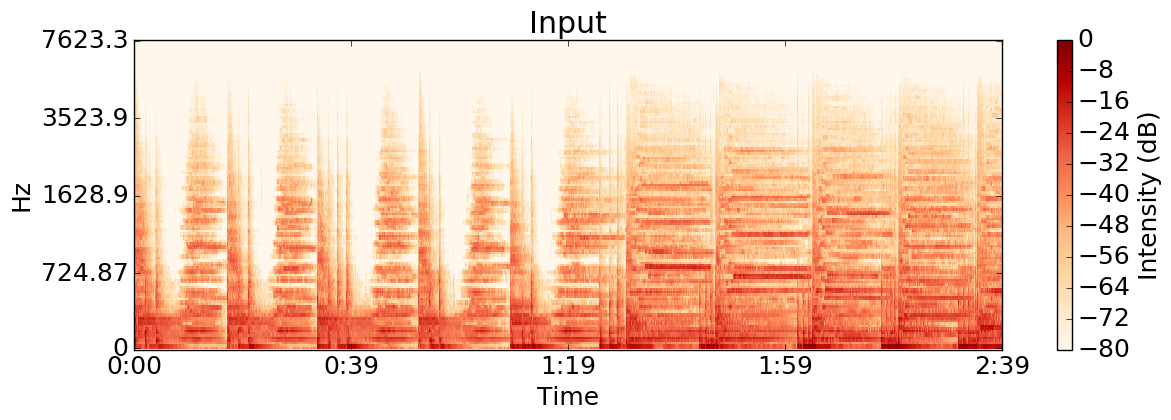

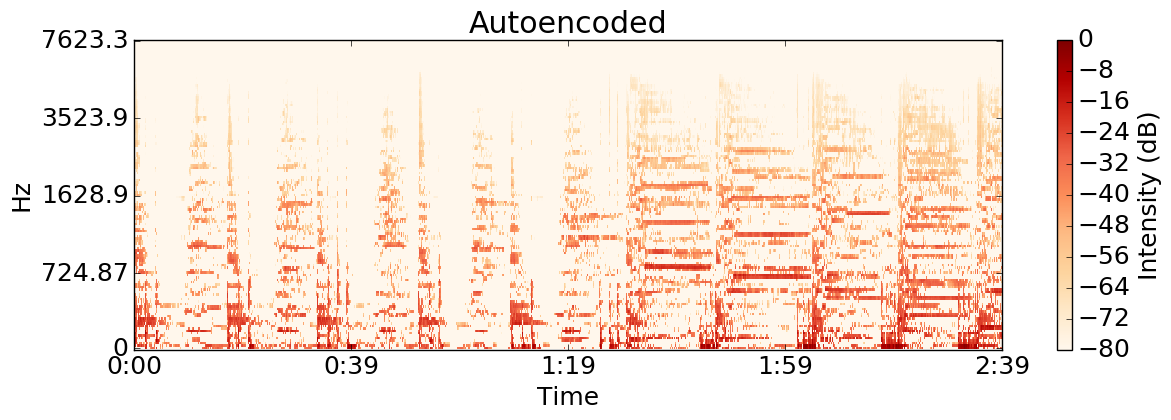

In [9]:
duration = track.size/fs
compare = range(0,total_length,1)
recon = sess.run(ae_dict['Y'], feed_dict={ ae_dict['X']: data.data[compare]})

original = data.data[compare]

M = []
for i,r in enumerate(original):
    M.append( r.reshape(freq_bins,time_bins)*std_img+mean_img )

M2 = np.hstack(M)
figure(figsize=(14,4))

librosa.display.specshow(librosa.logamplitude(M2,ref_power=np.max),hop_length = HOP*block_length/2.0,sr=fs*block_length,y_axis='mel', fmax=8000, x_axis='time')
title('Input')
colorbar(label='Intensity (dB)')
if SAVEFIG: savefig('../../talk/figs/'+ name +'_input.png')

M = []
for i,r in enumerate(recon):
    M.append( r.reshape(freq_bins,time_bins)*std_img )
    
M2 = np.hstack(M)
figure(figsize=(14,4))

librosa.display.specshow(librosa.logamplitude(M2,ref_power=np.max),hop_length = HOP*block_length/2.0,sr=fs*block_length,y_axis='mel', fmax=8000, x_axis='time')

title('Autoencoded');
colorbar(label='Intensity (dB)')


if SAVEFIG: savefig('../../talk/figs/'+ name +'_autoencoded.png')

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10


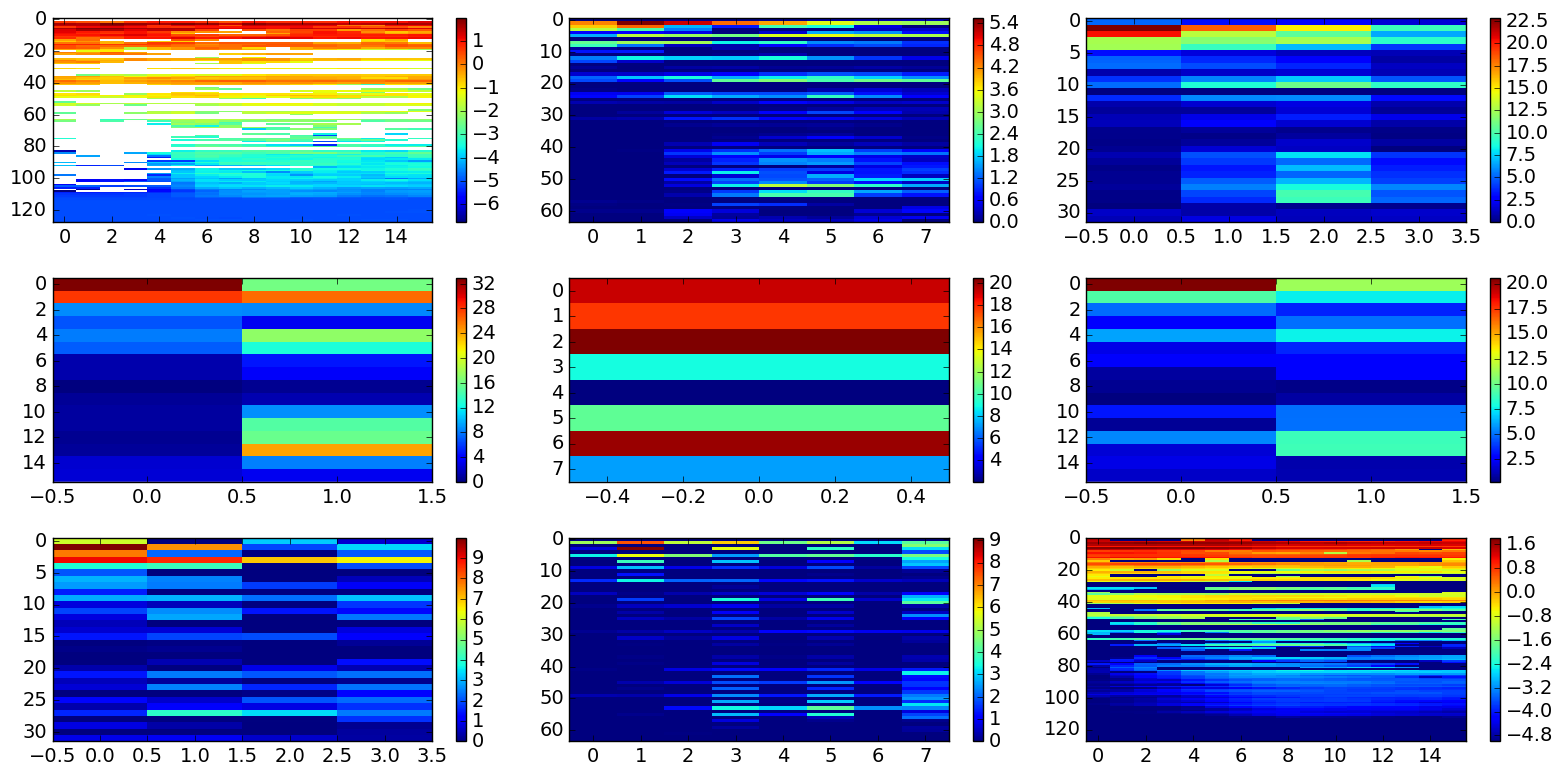

In [12]:
mpl.rc('font',size=14)
linputs = ae_dict['layers_inputs']

sample = 2
figure(figsize=(16,8))
for i,l in enumerate(linputs):
    recon = sess.run(l, feed_dict={ ae_dict['X']: data.data[sample:sample+1]})
    subplot(3,3,i+1)
    
    if i==0 or i== len(linputs)-1:
        out = recon[0,:,:,0]*std_img
        imshow(log10(out+0.00001),aspect='auto',interpolation='none')
    else:
        out = recon[0,:,:,0]
        imshow(out,aspect='auto',interpolation='none')

    colorbar();
    
tight_layout()    

(1721, 8, 1, 16)


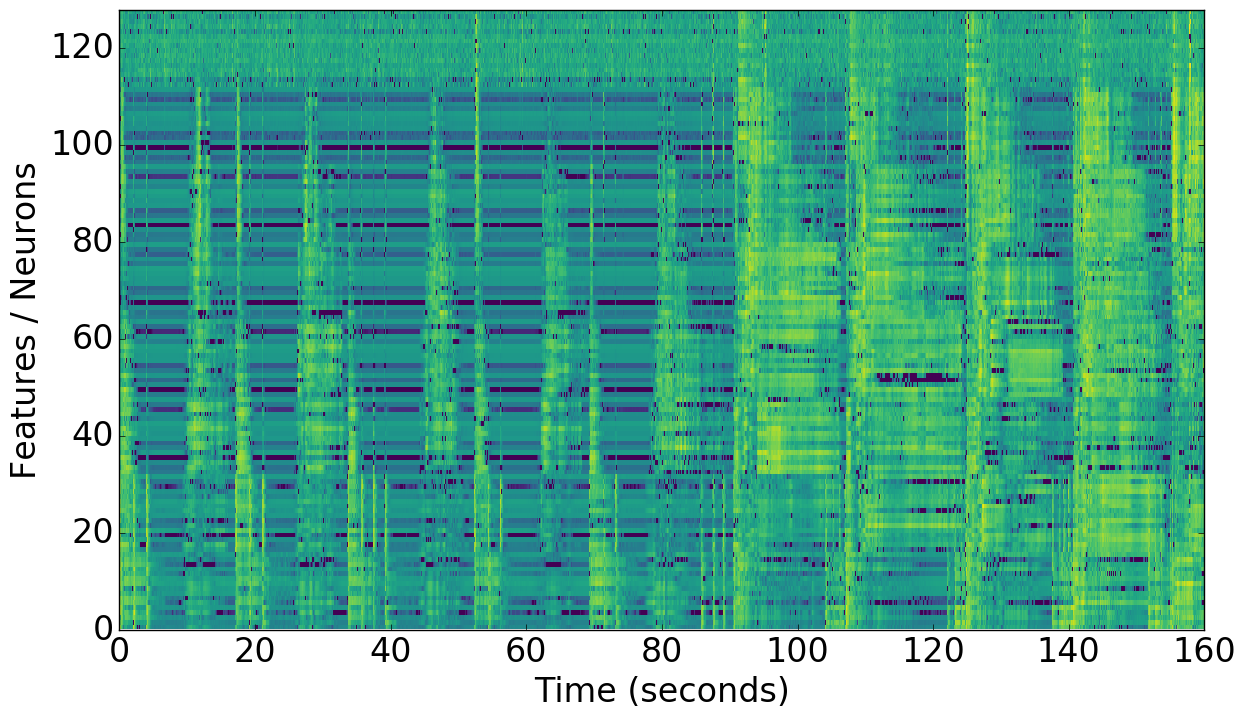

In [13]:
mpl.rc('font',size=24)
linputs = ae_dict['layers_inputs']

recon = sess.run(linputs[4], feed_dict={ ae_dict['X']: data.data})
print(recon.shape);
xd = recon.shape[0]
yd = recon.shape[1]*recon.shape[2]*recon.shape[3]
out = recon.reshape(xd,yd)

figure(figsize=(14,8))
imshow(log10(out.T+0.01),aspect='auto',interpolation='none',origin='bottom',cmap=cm.viridis,extent=[0,duration,0,M2.shape[0]])
xlabel('Time (seconds)')
ylabel('Features / Neurons' )

if SAVEFIG: savefig('../../talk/figs/'+name+'_innerlayer.png')